# Developement of optimization algorithm

In optimization_developement.ipynb I build a relatively simplemodel which can take different parameters as input and thus can be easily changed.

The next aim is developing an algorithm to find a good model. The difference compared to classical fitting is that the no constant truth which is fit, thus standard implementations of the usual algorithms do not work. 

First all needed libraries and own functions are imported.

In [1]:
import numpy as np
import random as random
import scipy
#using simpleguitk for display, is not needed for computer game
import simpleguitk as simplegui
import time
#new ones
import pandas as pd
#ml methods
from xgboost import XGBRegressor
from xgboost import XGBClassifier
#logistic regression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import os
#skyjo game classes and functions 
from skyjo_functions4 import *
#own functions for machine learning
from ml_functions2 import *
#for plotting 
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

#for confidence intervalls
from scipy.stats import beta
#for splitting
from sklearn.model_selection import train_test_split
#confusing matrix
from sklearn.metrics import confusion_matrix
#for saving and loading of stranger object
import pickle

Any fit needs to start with with at least one mdoel to play against. This very first is when all parameters are 0. 
Asd the next step I try a change only one parameter at a time the first step to a gradient based algorithm.
It has input the step sizes for all parameters and the number of relaizations the model is run. 

In [2]:
#means changes within the function do not have an effect outside of it , copy it to the top functions does not change anything 
def first_gradient_step(open_steps,discard_steps,value_steps,realizations):
    n_it=realizations
    results=np.zeros((40,19))
    for j in range(results.shape[1]):
        print(f"doing case {j}")
        level20_open_variable=np.zeros((6))
        level20_discard_variable=np.zeros((6))
        level20_value_variable=np.zeros((7))
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        if j<6:
            level21_open_variable[j]=open_steps[j]
        elif j<12:
            level21_discard_variable[j-6]=discard_steps[j-6]
        else:
            level21_value_variable[j-12]=value_steps[j-12]    
        print(level21_open_variable,level21_discard_variable,level21_value_variable)
        results[0:6,j]=level20_open_variable
        results[6:12,j]=level20_discard_variable
        results[12:19,j]=level20_value_variable    
        results[19:25,j]=level21_open_variable
        results[25:31,j]=level21_discard_variable
        results[31:38,j]=level21_value_variable         
        win20=0
        start_time=time.time()
        for i in range(n_it):
            names=['alpha','beta']
            nature=['computer','computer']
            levels=[20,21]
            winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
            if winner[0]==1:
                win20+=1
        results[38,j]=n_it
        results[39,j]=win20
        stop_time=time.time()
        print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
        print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
    return results     

I run it several times, with the aims of finding which parameter size matters for winning, since it is clear that it will saturate at some point since the range of outcomes is limited. 

In [27]:
factors=[-0.00005,-0.0001,-0.0002,-0.0005,-0.001,-0.002,-0.005,-0.01,-0.02,-0.05,-0.1]
for i in range(len(factors)):
    print(f"doing factor {factors[i]}")
    open_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    discard_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    value_step=[factors[i],factors[i],factors[i],factors[i],factors[i],factors[i],factors[i]]
    #does not recreated levls good 
    result=first_gradient_step(open_step,discard_step,value_step,400)
    #outcommented that it is not overwritten by chance
    #np.savetxt("gradient_level20_vm"+str(i)+".txt",result)

doing factor -5e-05
doing case 0
[-5.e-05  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.707 seconds
level 20 won to 45.0 %
doing case 1
[ 0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.628 seconds
level 20 won to 50.0 %
doing case 2
[ 0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.47 seconds
level 20 won to 49.0 %
doing case 3
[ 0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.62 seconds
level 20 won to 50.5 %
doing case 4
[ 0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05  0.e+00] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.127 seconds
level 20 won to 48.2 %
doing case 5
[ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -5.e-05] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 22.84 seconds
level 20 won to 49.0 %
doing case 6
[0. 0. 0. 0. 0. 

400 games need 22.451 seconds
level 20 won to 52.2 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.     -0.0002  0.      0.      0.      0.      0.    ]
400 games need 21.956 seconds
level 20 won to 48.2 %
doing case 14
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.     -0.0002  0.      0.      0.      0.    ]
400 games need 21.796 seconds
level 20 won to 49.5 %
doing case 15
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.     -0.0002  0.      0.      0.    ]
400 games need 21.297 seconds
level 20 won to 61.2 %
doing case 16
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.     -0.0002  0.      0.    ]
400 games need 21.807 seconds
level 20 won to 50.5 %
doing case 17
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.     -0.0002  0.    ]
400 games need 20.862 seconds
level 20 won to 57.5 %
doing case 18
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.      0.      0.      0.      0.      0.     -0.0002]
400 games 

400 games need 24.202 seconds
level 20 won to 49.8 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.     0.    -0.002  0.     0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.193 seconds
level 20 won to 41.5 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.    -0.002  0.     0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.484 seconds
level 20 won to 15.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.    -0.002  0.   ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 23.745 seconds
level 20 won to 41.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.     0.     0.     0.     0.    -0.002] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.914 seconds
level 20 won to 16.5 %
doing case 12
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [-0.002  0.     0.     0.     0.     0.     0.   ]
400 games need 21.812 seconds
level 20 won to 53.0 %
doing case 13
[0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0.] [ 0.    -0.002  0.     0.     0.     0.     0.   ]
400 games need 20.24 seconds
level 20 won to 67.8 %
doing case 14
[0. 

400 games need 25.533 seconds
level 20 won to 41.0 %
doing case 5
[ 0.    0.    0.    0.    0.   -0.02] [0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0.]
400 games need 25.576 seconds
level 20 won to 38.5 %
doing case 6
[0. 0. 0. 0. 0. 0.] [-0.02  0.    0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 24.114 seconds
level 20 won to 30.0 %
doing case 7
[0. 0. 0. 0. 0. 0.] [ 0.   -0.02  0.    0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.617 seconds
level 20 won to 32.2 %
doing case 8
[0. 0. 0. 0. 0. 0.] [ 0.    0.   -0.02  0.    0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.844 seconds
level 20 won to 18.2 %
doing case 9
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.   -0.02  0.    0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 26.598 seconds
level 20 won to 13.2 %
doing case 10
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.   -0.02  0.  ] [0. 0. 0. 0. 0. 0. 0.]
400 games need 27.52 seconds
level 20 won to 19.2 %
doing case 11
[0. 0. 0. 0. 0. 0.] [ 0.    0.    0.    0.    0.   

Running that time, that needs to be considered, that a fit does not take too long. Also since there is not a fully defined truth it is less important to be very good against a model, since it is more important to be good overall since a very good performance against a model could be just a good solution agianst this but not in general. 

Now I am loading all positive factors file and combine them in a file for plotting to find where the gradient flattens for the different parameters.

In [3]:
gra1=np.loadtxt("gradient_level20_v1.txt")
gra2=np.loadtxt("gradient_level20_v2.txt")
gra3=np.loadtxt("gradient_level20_v3.txt")
gra4=np.loadtxt("gradient_level20_v4.txt")
gra5=np.loadtxt("gradient_level20_v5.txt")
gra6=np.loadtxt("gradient_level20_v6.txt")
gra7=np.loadtxt("gradient_level20_v7.txt")
gra8=np.loadtxt("gradient_level20_v8.txt")
gra9=np.loadtxt("gradient_level20_v9.txt")
gra10=np.loadtxt("gradient_level20_v10.txt")
gra11=np.loadtxt("gradient_level20_v11.txt")
gra12=np.loadtxt("gradient_level20_v12.txt")
gra13=np.loadtxt("gradient_level20_v13.txt")
gra14=np.loadtxt("gradient_level20_v14.txt")
compp=np.zeros((20,14))
compp[0,:]=np.array([1,0.5,0.2,0.1,0.05,0.02,0.01,0.005,0.002,0.001,0.0005,0.0002,0.0001,0.00005])
compp[1:20,0]=gra1[39,:]/gra1[38,:]
compp[1:20,1]=gra2[39,:]/gra2[38,:]
compp[1:20,2]=gra3[39,:]/gra3[38,:]
compp[1:20,3]=gra4[39,:]/gra4[38,:]
compp[1:20,4]=gra5[39,:]/gra5[38,:]
compp[1:20,5]=gra6[39,:]/gra6[38,:]
compp[1:20,6]=gra7[39,:]/gra7[38,:]
compp[1:20,7]=gra8[39,:]/gra8[38,:]
compp[1:20,8]=gra9[39,:]/gra9[38,:]
compp[1:20,9]=gra10[39,:]/gra10[38,:]
compp[1:20,10]=gra11[39,:]/gra11[38,:]
compp[1:20,11]=gra12[39,:]/gra12[38,:]
compp[1:20,12]=gra13[39,:]/gra13[38,:]
compp[1:20,13]=gra14[39,:]/gra14[38,:]

Now I plot them, separately for three different actions which take parameters. Starting with the parameters for action of taking open pile card or not.

Text(0.5, 1.0, 'taking open pile card')

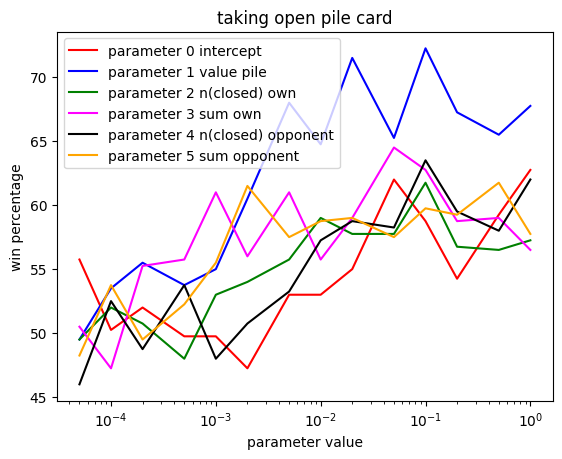

In [4]:
plt.plot(compp[0,:],100*compp[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

No action gets very large percentages here, but as expected the value of the open card matters most.

Text(0.5, 1.0, 'discarding closed pile card')

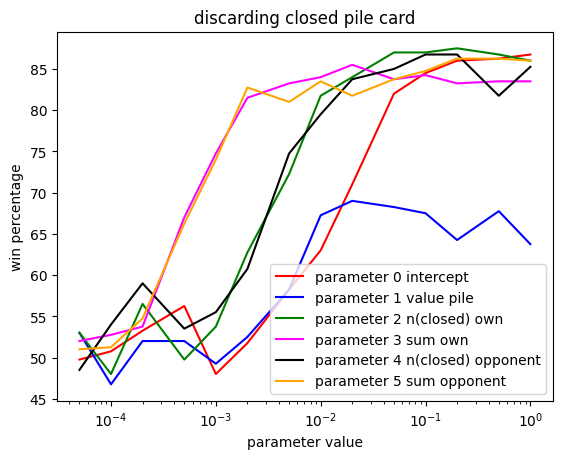

In [5]:
plt.plot(compp[0,:],100*compp[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Here the parameter more, since that is more related to finishing games first or second. In a random strategy finishing second is better since otherwise the score can be doubled when it is higher than the oppoenents. 
Sum matters for smaller paremeters because its numbers are smaller than for the number of closed cards and the values of cards. 

Text(0.5, 1.0, 'playing closed or maximum value')

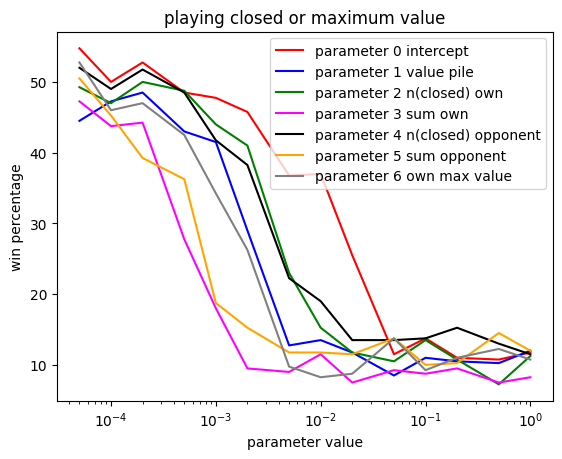

In [6]:
plt.plot(compp[0,:],100*compp[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compp[0,:],100*compp[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compp[0,:],100*compp[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compp[0,:],100*compp[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compp[0,:],100*compp[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compp[0,:],100*compp[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compp[0,:],100*compp[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

Similar as before, after the sum also the value of the maximum cards matters for the decision relatively much. 

It flattened always at most at 0.1.

Now the same for negative values of parameters. First collecting the values. 

In [7]:
gram1=np.loadtxt("gradient_level20_vm0.txt")
gram2=np.loadtxt("gradient_level20_vm1.txt")
gram3=np.loadtxt("gradient_level20_vm2.txt")
gram4=np.loadtxt("gradient_level20_vm3.txt")
gram5=np.loadtxt("gradient_level20_vm4.txt")
gram6=np.loadtxt("gradient_level20_vm5.txt")
gram7=np.loadtxt("gradient_level20_vm6.txt")
gram8=np.loadtxt("gradient_level20_vm7.txt")
gram9=np.loadtxt("gradient_level20_vm8.txt")
gram10=np.loadtxt("gradient_level20_vm9.txt")
gram11=np.loadtxt("gradient_level20_vm10.txt")
compm=np.zeros((20,11))
compm[0,:]=np.array([0.00005,0.0001,0.0002,0.0005,0.001,0.002,0.005,0.01,0.02,0.05,0.1])
compm[1:20,0]=gram1[39,:]/gram1[38,:]
compm[1:20,1]=gram2[39,:]/gram2[38,:]
compm[1:20,2]=gram3[39,:]/gram3[38,:]
compm[1:20,3]=gram4[39,:]/gram4[38,:]
compm[1:20,4]=gram5[39,:]/gram5[38,:]
compm[1:20,5]=gram6[39,:]/gram6[38,:]
compm[1:20,6]=gram7[39,:]/gram7[38,:]
compm[1:20,7]=gram8[39,:]/gram8[38,:]
compm[1:20,8]=gram9[39,:]/gram9[38,:]
compm[1:20,9]=gram10[39,:]/gram10[38,:]
compm[1:20,10]=gram11[39,:]/gram11[38,:]

Text(0.5, 1.0, 'taking open pile card')

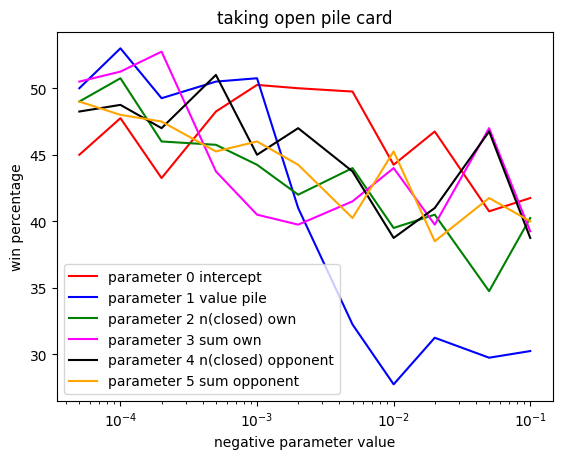

In [8]:
plt.plot(compm[0,:],100*compm[1,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[2,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[3,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[4,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[5,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[6,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("negative parameter value")
plt.ylabel("win percentage")
plt.title("taking open pile card")

As expected it is mostly the reverse of taking positive actions. Most deviations of it are likely chance. The same is visible below

Text(0.5, 1.0, 'discarding closed pile card')

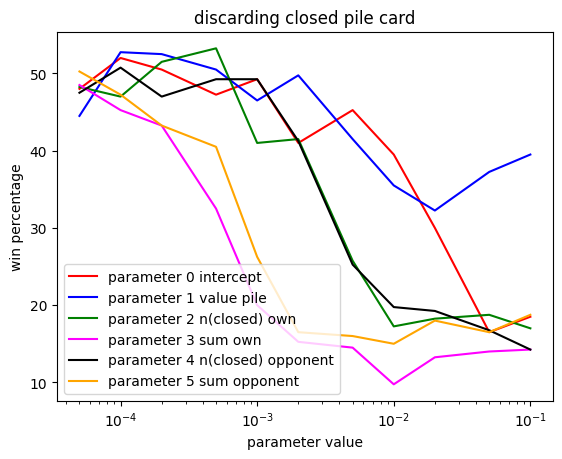

In [9]:

plt.plot(compm[0,:],100*compm[7,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[8,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[9,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[10,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[11,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[12,:],color='orange',label='parameter 5 sum opponent')  
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("discarding closed pile card")

Text(0.5, 1.0, 'playing closed or maximum value')

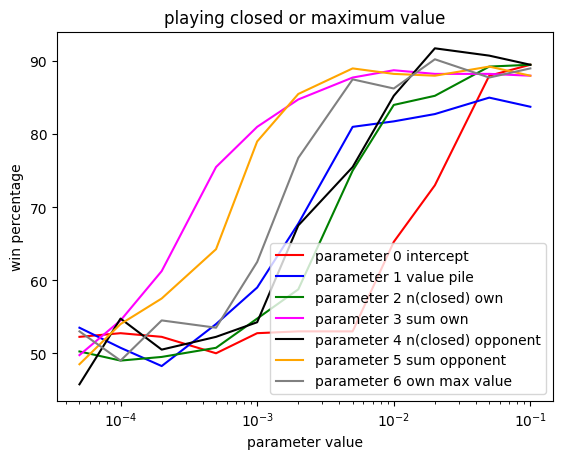

In [10]:
plt.plot(compm[0,:],100*compm[13,:],color='red',label='parameter 0 intercept') 
plt.plot(compm[0,:],100*compm[14,:],color='blue',label='parameter 1 value pile') 
plt.plot(compm[0,:],100*compm[15,:],color='green',label='parameter 2 n(closed) own') 
plt.plot(compm[0,:],100*compm[16,:],color='magenta',label='parameter 3 sum own') 
plt.plot(compm[0,:],100*compm[17,:],color='black',label='parameter 4 n(closed) opponent')  
plt.plot(compm[0,:],100*compm[18,:],color='orange',label='parameter 5 sum opponent') 
plt.plot(compm[0,:],100*compm[19,:],color='gray',label='parameter 6 own max value') 
plt.legend(loc="best")
plt.xscale("log")
plt.xlabel("parameter value")
plt.ylabel("win percentage")
plt.title("playing closed or maximum value")

As another exploring attenpt, I now constract a Monte Carlo procedure.
As the first step I create the function montecarlo_trials.
It takes lists of several model parameters as input. These are the levels 20. It plays against those by creating Monte Cralo model, the levels 21. They  are created randomly with given ranges. It creates a given number of of Monte Cralo trails, each with the same number of game realizations. 

In [11]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
def montecarlo_trials(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials):
    n_it=realizations
    results=np.zeros((40,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            print(np.round(level21_open_variable,5),np.round(level21_discard_variable,5),np.round(level21_value_variable,5))
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            start_time=time.time()
            for i in range(n_it):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            results[38,j,k]=n_it
            results[39,j,k]=win20
            stop_time=time.time()
            print(f"{n_it} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(win20*100/n_it,1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[39,j,:])*100/n_it,1)} %")   
    return results 

Now  I am testing the function.

In [17]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0))]
list_discard=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0))]
list_value=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0))]


res=montecarlo_trials(list_open,list_discard,list_value,op_range,dis_range,val_range,50,4)
np.save("mc_v3.npy",res)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 3.669 seconds
level 20 won to 4.0 %
trying case 1 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 3.019 seconds
level 20 won to 0.0 %
trying case 2 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
50 games need 2.064 seconds
level 20 won to 2.0 %
trying case 3 for level 20
[-0.04679 -0.08825  0.01073 -0.05236  0.04742  0.04028] [-0.09838 -0.03574  0.00178 -0.07373 -0.02169  0.05731] [ 0.01207  0.00757 -0.00177  0.05194  0.0767  -0.08258  0.03525]
5

Below I plot an example. 

Text(0, 0.5, 'level 20 wins [%]')

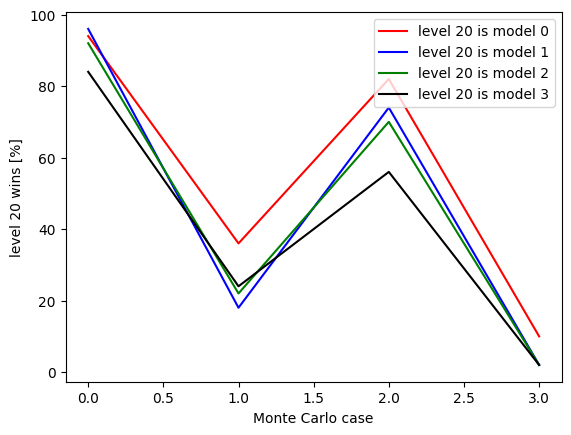

In [18]:
res3=np.load("mc_v2.npy")
plt.plot(range(4),res3[39,:,0]/res3[38,:,0]*100,color='red',label='level 20 is model 0') 
plt.plot(range(4),res3[39,:,1]/res3[38,:,0]*100,color='blue',label='level 20 is model 1') 
plt.plot(range(4),res3[39,:,2]/res3[38,:,0]*100,color='green',label='level 20 is model 2') 
plt.plot(range(4),res3[39,:,3]/res3[38,:,0]*100,color='black',label='level 20 is model 3') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

Rather easy to improve compared to the current models. Below I print the parameters of the best case that they can be easily used for human trial. 

In [16]:
print(res3[19:25,3,2])
print(res3[25:31,3,2])
print(res3[31:38,3,2])

[ 0.01940094  0.05146526 -0.02648223 -0.07416882 -0.00188127 -0.01222425]
[ 0.07948311  0.05037697  0.00790461 -0.03574202  0.01697387 -0.05714196]
[-0.05759114  0.07014045 -0.05425065  0.09631128 -0.06878424 -0.00164203
  0.08420359]


As another test I include this model in the list of input models. It should clearly harder to win against this one. 

In [18]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

list_open2=[np.array((0.,0.,0.,0.,0.,0.)),np.array((0,0.02,0,0,0,0)),np.array((0.,0,0,0,0,0)),np.array((0.,0,0,0,0,0)),res3[19:25,3,2]]
list_discard2=[np.array((0,0,0.,0,0,0)),np.array((0,0,0,0,0,0.)),np.array((0,0,0,0.02,0,0)),np.array((0,0,0.,0,0,0)),res3[25:31,3,2]]
list_value2=[np.array((0.,0,0,0,0,0,0)),np.array((0,0,0,0.,0,0,0)),np.array((0,0,0,0,0,0,0)),np.array((0,0,0,-0.01,0,0,0)),res3[31:38,3,2]]

res2=montecarlo_trials(list_open2,list_discard2,list_value2,op_range,dis_range,val_range,50,5)
np.save("mc_v6.npy",res2)

doing Monte Carlo 0 for level 21
trying case 0 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 3.768 seconds
level 20 won to 38.0 %
trying case 1 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.397 seconds
level 20 won to 4.0 %
trying case 2 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]
50 games need 2.451 seconds
level 20 won to 24.0 %
trying case 3 for level 20
[-0.05578  0.08107  0.0721   0.01121 -0.08385  0.04489] [ 0.07796  0.09251 -0.09946 -0.07437  0.02669 -0.09287] [-0.01844  0.04515  0.09698  0.00047 -0.07023  0.05586  0.06344]

Below I plot the winning percentages of these comparisons. 

Text(0, 0.5, 'level 20 wins [%]')

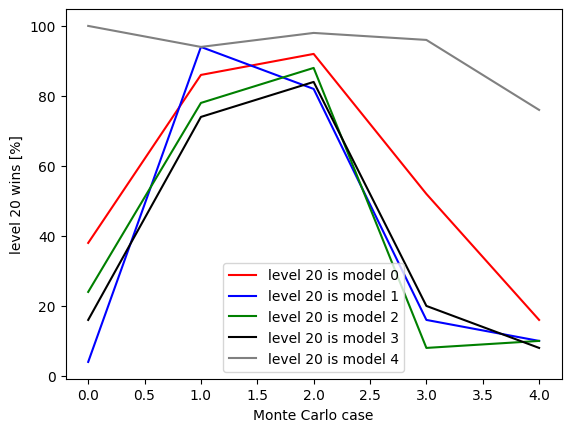

In [20]:
res2=np.load("mc_v6.npy")
plt.plot(range(5),res2[39,:,0]/res2[38,:,0]*100,color='red',label='level 20 is model 0') 
plt.plot(range(5),res2[39,:,1]/res2[38,:,0]*100,color='blue',label='level 20 is model 1') 
plt.plot(range(5),res2[39,:,2]/res2[38,:,0]*100,color='green',label='level 20 is model 2') 
plt.plot(range(5),res2[39,:,3]/res2[38,:,0]*100,color='black',label='level 20 is model 3') 
plt.plot(range(5),res2[39,:,4]/res2[38,:,0]*100,color='gray',label='level 20 is model 4')
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("Monte Carlo case")
plt.ylabel("level 20 wins [%]")

As expected the latest model (model 4) performs clearly better than the other models. 

Now I am changing the function somewhat to make it faster by stopping it early when either a good model is found 
or a Monte Carlo realization is clearly (not) an improvement. Below I first calculate how iterations are at least needed, that a test whether the fit is clear bad/good makes sense. I excluded cases which to 98% not from a Gaussian distribution on both sides that correspinds to 2.33 sigma. 

In [64]:
x=100
sig=(0-x/2)/np.sqrt(x)
print(sig)
#sig**2=(x**2)/4/x
#sig**2=x/4
sig2=2.33
x2=(sig2**2)*4
print(x2)


-5.0
21.715600000000002


The results if that for n greater equal 22 a significance test makes sense. This number is larger enough that using the Gaussian approxiamtions for a a in principel bionamial varaible is good enough that differences don't matter in practice. 

In [79]:
#does Monte carlo against a number of cases
#open_vars and co and and are lists of the variables to be used 
#open_ranges and discard_ranges are 2,6 np arrays, value_ranges is 2,7 np array, 
#reliazations are number of models tried in one, trials are number of MC models for level 21
#wfrac when it aborts early
#wfrac2 performance of worst case .
def montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=0.10,wfrac2=0.551):
    n_it=realizations
    results=np.zeros((41,trials,len(open_vars)))
    for j in range(trials):
        print(f"doing Monte Carlo {j} for level 21")
        #create random values for level 21 within the ranges, save are used for all level 20 models
        level21_open_variable=np.zeros((6))
        level21_discard_variable=np.zeros((6))
        level21_value_variable=np.zeros((7))
        for k in range(7):
            level21_value_variable[k]=value_ranges[0,k]+random.random()*(value_ranges[1,k]-value_ranges[0,k])
            if k<6:
                level21_open_variable[k]=open_ranges[0,k]+random.random()*(open_ranges[1,k]-open_ranges[0,k])
                level21_discard_variable[k]=discard_ranges[0,k]+random.random()*(discard_ranges[1,k]-discard_ranges[0,k])
        for k in range(len(open_vars)):
            print(f"trying case {k} for level 20")
            level20_open_variable=np.array(open_vars[k])
            level20_discard_variable=np.array(discard_vars[k])
            level20_value_variable=np.array(value_vars[k])             
            results[0:6,j,k]=level20_open_variable
            results[6:12,j,k]=level20_discard_variable
            results[12:19,j,k]=level20_value_variable    
            results[19:25,j,k]=level21_open_variable
            results[25:31,j,k]=level21_discard_variable
            results[31:38,j,k]=level21_value_variable         
            win20=0
            it_counter=0
            start_time=time.time()
            n_it1=n_it
            if n_it1>22:
                n_it1=22
            #22 always     
            for i in range(n_it1):
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1
            #98% ownside win conditions tested here   2.33 sigma   stops early when new model clearly bad or good 
            while it_counter<n_it and abs((win20-it_counter/2)/np.sqrt(it_counter))<2.33:  
                names=['alpha','beta']
                nature=['computer','computer']
                levels=[20,21]
                it_counter+=1
                winner=skyjo_game(names,nature,levels,0,True,False,level20_open_variable=level20_open_variable,level21_open_variable=level21_open_variable,level20_discard_variable=level20_discard_variable,level21_discard_variable=level21_discard_variable,level20_value_variable=level20_value_variable,level21_value_variable=level21_value_variable)
                if winner[0]==1:
                    win20+=1                
            #now checking whether 98% sigficant on bad performance        
            results[38,j,k]=it_counter
            results[39,j,k]=win20
            results[40,j,k]=100*win20/it_counter         
            stop_time=time.time()
            print(f"{it_counter} games need {np.round(stop_time-start_time,3)} seconds")
            print(f"level 20 won to {np.round(results[40,j,k],1)} %")
        print(f"level 20 won in average to {np.round(np.mean(results[40,j,:]),1)} %") 
        if np.mean(results[40,j,:]/100)<wfrac and np.max(results[40,j,:]/100)<wfrac2:
            print("better model found")
            if j==0:
                return True, results[:,j,:], results[:,j,:]
            else:
                #give back fit converged or not, best models, all models 
                return True, results[:,j,:], results[:,0:j+1,:]
    print("no better model found") 
    #second parameter is noen will not be used later
    return False, None, results 

Now I am running for a test.

In [207]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

#load past iteration
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)      
print(list_open5)
print(list_discard5)
print(list_value5)

start_time=time.time()
boolean,bestres,allres=montecarlo_trials2(list_open5,list_discard5,list_value5,op_range,dis_range,val_range,50,850,wfrac=0.001,wfrac2=0.002)
#v8/v9 on purpose impossible crieteria to just run all iterations with predictable operation duration
np.save("mc_v9_all.npy",allres)
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")
#v8 20 trials need 418 second thus one trial need 21 seconds 

[array([ 0.01940094,  0.05146526, -0.02648223, -0.07416882, -0.00188127,
       -0.01222425]), array([ 0.06411199, -0.06714365, -0.06118923, -0.07942706,  0.00706517,
       -0.09106071]), array([-0.03454234, -0.07293471,  0.03456145, -0.08240488, -0.01995018,
        0.01688238]), array([-0.03837573, -0.03494162,  0.06913455, -0.02994554,  0.00301286,
        0.00258103]), array([ 0.08420437,  0.01523879, -0.04838138,  0.04800721, -0.0470724 ,
       -0.09039604]), array([ 0.04234292, -0.07189049, -0.06083353,  0.06398506,  0.05762561,
       -0.06334734])]
[array([ 0.07948311,  0.05037697,  0.00790461, -0.03574202,  0.01697387,
       -0.05714196]), array([ 0.08944088,  0.0080087 ,  0.09545899, -0.06307576, -0.02390966,
        0.01762127]), array([ 0.05187052, -0.04812191,  0.05987011, -0.09685987, -0.03279703,
       -0.06690501]), array([-0.06190827,  0.00287039,  0.09979345, -0.05605547,  0.04381588,
        0.02095178]), array([-0.04095933,  0.02911903,  0.05907581, -0.06453082,

22 games need 0.989 seconds
level 20 won to 100.0 %
trying case 1 for level 20
22 games need 1.001 seconds
level 20 won to 100.0 %
trying case 2 for level 20
22 games need 0.984 seconds
level 20 won to 100.0 %
trying case 3 for level 20
22 games need 1.025 seconds
level 20 won to 100.0 %
trying case 4 for level 20
22 games need 1.0 seconds
level 20 won to 100.0 %
trying case 5 for level 20
22 games need 1.386 seconds
level 20 won to 100.0 %
level 20 won in average to 100.0 %
doing Monte Carlo 13 for level 21
trying case 0 for level 20
22 games need 0.614 seconds
level 20 won to 100.0 %
trying case 1 for level 20
22 games need 0.546 seconds
level 20 won to 100.0 %
trying case 2 for level 20
22 games need 0.589 seconds
level 20 won to 100.0 %
trying case 3 for level 20
22 games need 0.515 seconds
level 20 won to 100.0 %
trying case 4 for level 20
22 games need 0.565 seconds
level 20 won to 100.0 %
trying case 5 for level 20
22 games need 0.57 seconds
level 20 won to 100.0 %
level 20 won 

Below I am printing the output for a test. 

In [264]:
allres=np.load("mc_v8_all.npy")
print("win % of level 20, mean over different level 20")
print(np.round(np.mean(allres[40,:,:],0),3))
print("win % of level 20, mean over different level 21")
print(np.round(np.mean(allres[40,:,:],1),3))

win % of level 20, mean over different level 20
[86.696 90.739 91.577 91.065 94.131 94.505]
win % of level 20, mean over different level 21
[100.     91.747  98.077  98.077  96.866  33.185  90.177  97.607  97.276
 100.     93.529  92.897 100.    100.    100.     91.248  98.077  97.436
  55.     97.844]
857.1428571428571


Since model 20 is iteratively improved it should getter, and this is the case against the random model 21 here. 
In contrast the different Monte Carlos (model 21) there is no improve,ent and in most case level 20 is better. 

Now I am building the Monte Carlo fitting function. 
  

First I create to helper functions to convert list of array output to numpy output.

In [220]:
#using input arrays of varaible shape[1] where the largest the the last one 
#only possible if there is one to add
def bestfit_to_array(list_best):
    if len(list_best)>0:
        last=list_best[len(list_best)-1]
        results=np.zeros((last.shape[0],last.shape[1],len(list_best)))
        #set not filled values to -100 to be clearly impossible
        results[:,:,:]=-100
        for i in range(len(list_best)):
            results[0:list_best[i].shape[0],0:list_best[i].shape[1],i]=list_best[i]
        return results  
    else:
        print("List is of length 0, no combination possible.")
        results=np.array([-100.])
        return results

Below I test the function. 

In [222]:
list2=[]
print(list2)
res=bestfit_to_array(list2)
print(res.shape,res)
list2=[np.zeros((41,5))]
print(list2[0].shape)
res=bestfit_to_array(list2)
print(res.shape)
list2=[np.zeros((6,5)),np.zeros((6,6))]
print(list2[0].shape)
res=bestfit_to_array(list2)
print(res.shape)

[]
List is of length 0, no combination possible.
(1,) [-100.]
(41, 5)
(41, 5, 1)
(6, 5)
(6, 6, 2)


Next the similar function which works on lists of 3d arrays. 

In [183]:
#works on list of 3d arrays, also of length 1 not of length 0, but that should not possible 
def allfits_to_array(list_all):
    if len(list_all)>0:
        dims=np.zeros((3,len(list_all)))
        for i in range(len(list_all)):
            dims[:,i]=list_all[i].shape
        results=np.zeros((int(max(dims[0,:])),int(max(dims[1,:])),int(max(dims[2,:])),len(list_all)))
        results[:]=-100  
        for i in range(len(list_all)):
            results[0:list_all[i].shape[0],0:list_all[i].shape[1],0:list_all[i].shape[2],i]=list_all[i]
        return results 
    else:
        print("List is of length 0, no combination possible.")
        results=np.array([-100.])
        return results

Below I test the function. 

In [185]:
list2=[]
print(list2)
res=allfits_to_array(list2)
print(res.shape,res)
list2=[np.zeros((41,5,2))]
print(list2[0].shape)
res=allfits_to_array(list2)
print(res.shape)
list2=[np.zeros((41,5,2)),np.zeros((40,4,3))]
print(list2[0].shape,list2[1].shape)
res=allfits_to_array(list2)
print(res.shape)

[]
List is of length 0, no combination possible.
(1,) [-100.]
(41, 5, 2)
(41, 5, 2, 1)
(41, 5, 2) (40, 4, 3)
(41, 5, 3, 2)


Now to the MonteCarlo fit function itself. 
It start with a list of input moel parameters and adds to it iteratively more models which perform at least somewhat better. If no such model is found the fit ends early.

In [225]:
#paarmeters, list of open parameters,  list of discard parameters, list of value parameters,
#open parameter ranges, discard parameter ranges, value parameter ranges,
#maximum number of games palyed for model pair. 
#Maximum number of Monte carlo pairs, 
#maxium number of added models tried,
#wfrac average maximum win fraction  for level 20, #wfrac2 maximum win fraction for single level 20 model
#both need to be smaller
def montecarlo_fit(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations=50,trials=10,max_iter=10,wfrac=0.10,wfrac2=0.5):
    #list to performances of winner models
    list_best_result=[]
    list_all_results=[]
    for i in range(max_iter):
        print(f"iteration {i} using {len(open_vars)} level 20 models")
        boolean,best_result,all_results=montecarlo_trials2(open_vars,discard_vars,value_vars,open_ranges,discard_ranges,value_ranges,realizations,trials,wfrac=wfrac,wfrac2=wfrac2)
        # good model found
        if boolean==True:
            #append this model
            open_vars.append(best_result[19:25,0])
            discard_vars.append(best_result[25:31,0])
            value_vars.append(best_result[31:38,0])
            print("model to append found")
            print(f"best model won to {np.round(100-np.mean(best_result[40,:]),1)} %")
            list_best_result.append(best_result)
            list_all_results.append(all_results)
        else:
            #no better found, still data collected but not ;best model added'      
            print("no model to append found iterations stopped early")
            list_all_results.append(all_results)
            array_best_result=bestfit_to_array(list_best_result)
            array_all_results=allfits_to_array(list_all_results)    
            return open_vars, discard_vars, value_vars,array_best_result,array_all_results 
    print("all iterations done")
    #converting lists to arrays
    array_best_result=bestfit_to_array(list_best_result)
    array_all_results=allfits_to_array(list_all_results)    
    return open_vars, discard_vars, value_vars,array_best_result,array_all_results    
#should also put all model and to save performances 

Below I run, shown is a short run, longer were run and saved before. 

In [229]:
op_range=np.zeros((2,6))
op_range[0,:]=-0.1
op_range[1,:]=0.1

dis_range=np.zeros((2,6))
dis_range[0,:]=-0.1
dis_range[1,:]=0.1

val_range=np.zeros((2,7))
val_range[0,:]=-0.1
val_range[1,:]=0.1

#load past iteration
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)      
print(list_open5)
print(list_discard5)
print(list_value5)

#printing more than it should shape and best min 
start_time=time.time()
list_open3,list_discard3,list_value3,array_bestres3,array_allres3=montecarlo_fit(list_open5,list_discard5,list_value5,op_range,dis_range,val_range,realizations=50,trials=5,wfrac=0.45,max_iter=3,wfrac2=0.6)
np.save("mc_v6_list_res.npy",array_bestres3)
np.save("mc_v6_list_allres.npy",array_allres3)
with open('mc_v6_list_open.pkl', 'wb') as f:
    pickle.dump(list_open3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v6_list_discard.pkl', 'wb') as f:
    pickle.dump(list_discard3, f, pickle.HIGHEST_PROTOCOL)
with open('mc_v6_list_value.pkl', 'wb') as f:
    pickle.dump(list_value3, f, pickle.HIGHEST_PROTOCOL)    
stop_time=time.time()
print(f"ran for {np.round(stop_time-start_time,2)} seconds")


[array([ 0.01940094,  0.05146526, -0.02648223, -0.07416882, -0.00188127,
       -0.01222425]), array([ 0.06411199, -0.06714365, -0.06118923, -0.07942706,  0.00706517,
       -0.09106071]), array([-0.03454234, -0.07293471,  0.03456145, -0.08240488, -0.01995018,
        0.01688238]), array([-0.03837573, -0.03494162,  0.06913455, -0.02994554,  0.00301286,
        0.00258103]), array([ 0.08420437,  0.01523879, -0.04838138,  0.04800721, -0.0470724 ,
       -0.09039604]), array([ 0.04234292, -0.07189049, -0.06083353,  0.06398506,  0.05762561,
       -0.06334734])]
[array([ 0.07948311,  0.05037697,  0.00790461, -0.03574202,  0.01697387,
       -0.05714196]), array([ 0.08944088,  0.0080087 ,  0.09545899, -0.06307576, -0.02390966,
        0.01762127]), array([ 0.05187052, -0.04812191,  0.05987011, -0.09685987, -0.03279703,
       -0.06690501]), array([-0.06190827,  0.00287039,  0.09979345, -0.05605547,  0.04381588,
        0.02095178]), array([-0.04095933,  0.02911903,  0.05907581, -0.06453082,

Now loading past fits result. The loaded fit had not yet an extra condition on the best level 20 model. I make a plot on the win percentage

(41, 12, 8)
[-0.09923392  0.03984586  0.03498189 -0.00576379 -0.00164228 -0.03251231
  0.02618759 -0.08613913  0.06374869 -0.08448752 -0.02141158 -0.01957679
 -0.09295743  0.03691107  0.00654938  0.00254979  0.08551578  0.01504413
  0.09738389]
[-0.09923392  0.03984586  0.03498189 -0.00576379 -0.00164228 -0.03251231
  0.02618759 -0.08613913  0.06374869 -0.08448752 -0.02141158 -0.01957679
 -0.09295743  0.03691107  0.00654938  0.00254979  0.08551578  0.01504413
  0.09738389]
68
[ 5.  6.  7.  8.  9. 10. 11. 12.]


Text(0, 0.5, 'Level 21 model')

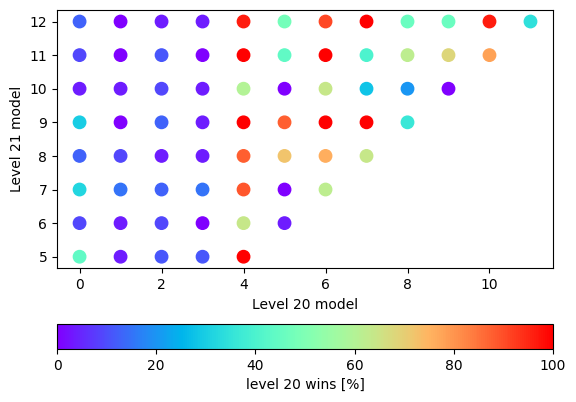

In [263]:
with open('mc_v1_list_res.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_res3b = pickle.load(f)   
res5=bestfit_to_array(list_res3b)
#below need to make to function best also consider for cases of model sharing 
grid = np.indices((res5[40,:,:].shape[0],res5[40,:,:].shape[1]))
print(res5.shape)
counter=0
vec=np.zeros((res5.shape[2]))
vec[:]=-1
print(res5[0:19,5,1])
print(res5[19:38,4,0])
for i in range(res5.shape[1]):
    for j in range(res5.shape[2]):
        if res5[40,i,j]>-1:
            counter+=1
            for k in range(res5.shape[1]):
                for l in range(res5.shape[2]):          
                    if np.sum(res5[0:19,i,j])==np.sum(res5[19:38,k,l]): 
                        vec[l]=i
print(counter)  
vec[vec.shape[0]-1]=vec[vec.shape[0]-2]+1
print(vec)
counter=0
results=np.zeros((4,68))   
for i in range(res5.shape[1]):
    for j in range(res5.shape[2]):
        if res5[40,i,j]>-1:
            results[0,counter]=i
            results[1,counter]=j
            results[2,counter]=vec[j]
            results[3,counter]=res5[40,i,j]
            counter+=1
#plt.plot(grid[0],grid[1],'o',color='red') 
plt.scatter(x=results[0], y=results[2], c=results[3,:],s=80, cmap="rainbow")
plt.colorbar(label="level 20 wins [%]", orientation="horizontal")
#plt.xscale("log")
plt.xlabel("Level 20 model")
plt.ylabel("Level 21 model")
plt.title("Model numbers are shared here")

It is visible that it is easy to be better than the models 0 to 3, for them at most one parameter is different from 0 models, but then it gets more difficult. 

Since these models are not particular good, they are now ignored. 

Below I load the model parameters of the currently acceptable models. 

6


Text(0.5, 1.0, 'open parameters')

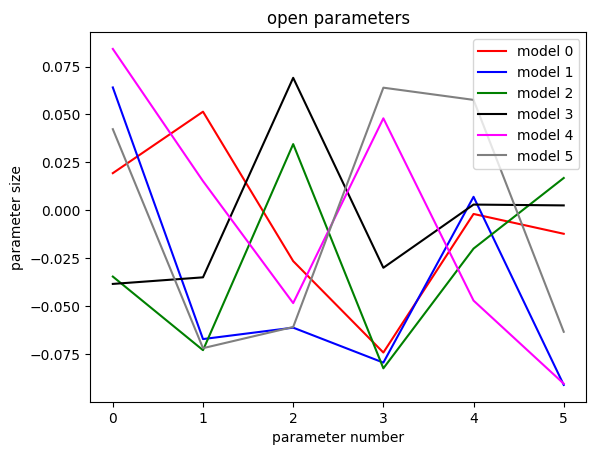

In [198]:
with open('mc_v5_list_open.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_open5 = pickle.load(f)   
with open('mc_v5_list_discard.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_discard5 = pickle.load(f)  
with open('mc_v5_list_value.pkl', 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    list_value5 = pickle.load(f)  
print(len(list_open5))    
plt.plot(range(6),list_open5[0],color='red',label='model 0') 
plt.plot(range(6),list_open5[1],color='blue',label='model 1') 
plt.plot(range(6),list_open5[2],color='green',label='model 2') 
plt.plot(range(6),list_open5[3],color='black',label='model 3') 
plt.plot(range(6),list_open5[4],color='magenta',label='model 4')
plt.plot(range(6),list_open5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("open parameters")

Text(0.5, 1.0, 'discard parameters')

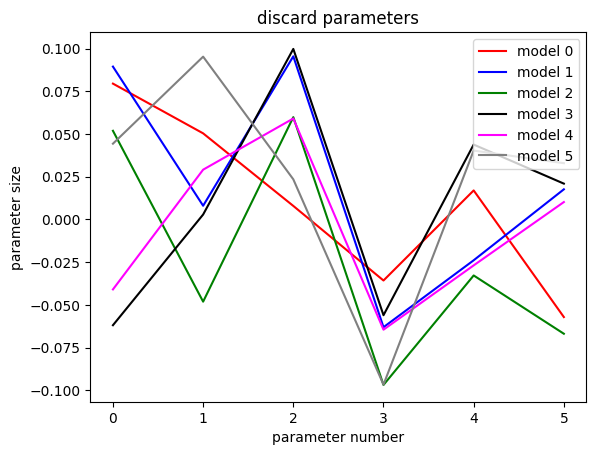

In [199]:
plt.plot(range(6),list_discard5[0],color='red',label='model 0') 
plt.plot(range(6),list_discard5[1],color='blue',label='model 1') 
plt.plot(range(6),list_discard5[2],color='green',label='model 2') 
plt.plot(range(6),list_discard5[3],color='black',label='model 3') 
plt.plot(range(6),list_discard5[4],color='magenta',label='model 4')
plt.plot(range(6),list_discard5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("discard parameters")

Here in discard is the clearest preference, for 2 (number of own closed cards) for large and for 3 (sum of own open cards)for small.

Text(0.5, 1.0, 'value parameters')

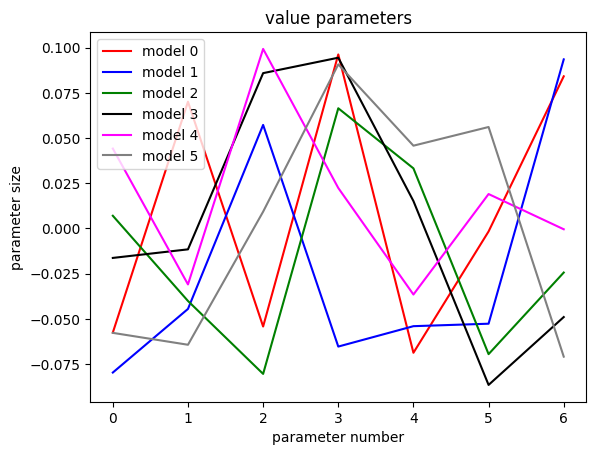

In [200]:
plt.plot(range(7),list_value5[0],color='red',label='model 0') 
plt.plot(range(7),list_value5[1],color='blue',label='model 1') 
plt.plot(range(7),list_value5[2],color='green',label='model 2') 
plt.plot(range(7),list_value5[3],color='black',label='model 3') 
plt.plot(range(7),list_value5[4],color='magenta',label='model 4')
plt.plot(range(7),list_value5[5],color='gray',label='model 5') 
plt.legend(loc="best")
#plt.xscale("log")
plt.xlabel("parameter number")
plt.ylabel("parameter size")
plt.title("value parameters")